[**RUN CODE**](https://colab.research.google.com/drive/1jcv54i46zHnGKKN1mXWskte3nr_mDee9?usp=sharing)

# Import Libraries

In [1]:
!pip install --quiet shap==0.39.0

     |████████████████████████████████| 356 kB 5.0 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import shap



sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/vaasu2002/PROJECTS/main/Machine%20Learning/Road%20Traffic%20Severity%20Classification/Data/RTA%20Dataset.csv")

In [4]:
df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


# Exploratory Data Analysis

In [5]:
df.shape

(12316, 32)

In [6]:
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [7]:
# renaming columns
col_map={
    'Time': 'time',
    'Day_of_week': 'day_of_week',
    'Age_band_of_driver': 'driver_age',
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level',
    'Vehicle_driver_relation': 'vehicle_driver_relation',
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_allignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'road_surface_conditions',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex' , 
    'Age_band_of_casualty': 'casualty_age', 
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casualty_work', 
    'Fitness_of_casuality': 'casualty_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}
df.rename(columns=col_map, inplace=True)

In [8]:
# converting 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     12316 non-null  datetime64[ns]
 1   day_of_week              12316 non-null  object        
 2   driver_age               12316 non-null  object        
 3   driver_sex               12316 non-null  object        
 4   educational_level        11575 non-null  object        
 5   vehicle_driver_relation  11737 non-null  object        
 6   driving_experience       11487 non-null  object        
 7   vehicle_type             11366 non-null  object        
 8   vehicle_owner            11834 non-null  object        
 9   service_year             8388 non-null   object        
 10  vehicle_defect           7889 non-null   object        
 11  accident_area            12077 non-null  object        
 12  lanes                    11931 n

In [10]:
df.describe(include=['O']).T

,count,unique,top,freq
day_of_week,12316,7,Friday,2041
driver_age,12316,5,18-30,4271
driver_sex,12316,3,Male,11437
educational_level,11575,7,Junior high school,7619
vehicle_driver_relation,11737,4,Employee,9627
driving_experience,11487,7,5-10yr,3363
vehicle_type,11366,17,Automobile,3205
vehicle_owner,11834,4,Owner,10459
service_year,8388,6,Unknown,2883
vehicle_defect,7889,3,No defect,7777


In [11]:
df.describe()

,vehicles_involved,casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000


In [12]:
df.isna().sum()

time                          0
day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident

In [13]:
# print duplicates
print("Number of duplicates: ", df.duplicated().sum())
print("Unique values per column:")
df.nunique()

Number of duplicates:  0
Unique values per column:


time                       1074
day_of_week                   7
driver_age                    5
driver_sex                    3
educational_level             7
vehicle_driver_relation       4
driving_experience            7
vehicle_type                 17
vehicle_owner                 4
service_year                  6
vehicle_defect                3
accident_area                14
lanes                         7
road_allignment               9
junction_type                 8
surface_type                  5
road_surface_conditions       4
light_condition               4
weather_condition             9
collision_type               10
vehicles_involved             6
casualties                    8
vehicle_movement             13
casualty_class                4
casualty_sex                  3
casualty_age                  6
casualty_severity             4
casualty_work                 7
casualty_fitness              5
pedestrian_movement           9
accident_cause               20
accident

In [14]:
# extracting hour and minute from timestamp
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.drop('time', axis=1, inplace=True)

In [15]:
df.head()

,day_of_week,driver_age,driver_sex,educational_level,vehicle_driver_relation,driving_experience,vehicle_type,vehicle_owner,service_year,vehicle_defect,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_work,casualty_fitness,pedestrian_movement,accident_cause,accident_severity,hour,minute
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury,17,2
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,17,2
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury,17,2
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury,1,6
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury,1,6


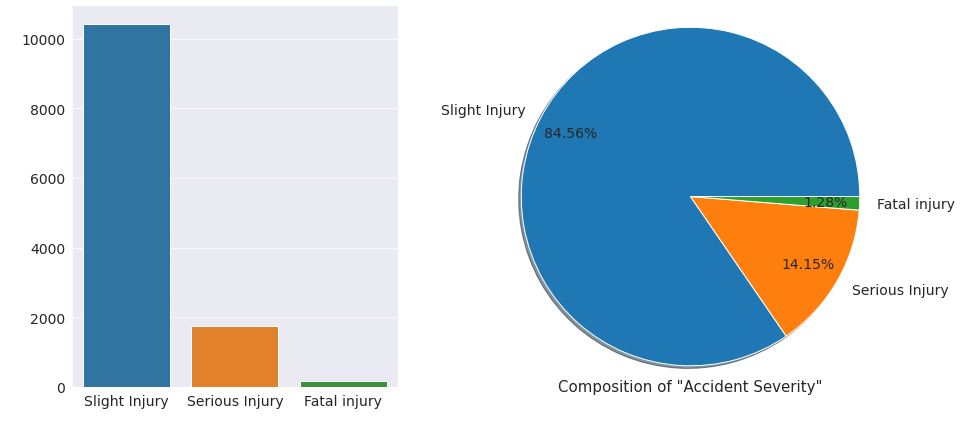

In [16]:
# checking the target
plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=df["accident_severity"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df["accident_severity"].value_counts(),
        labels=list(df["accident_severity"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Composition of "Accident Severity"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

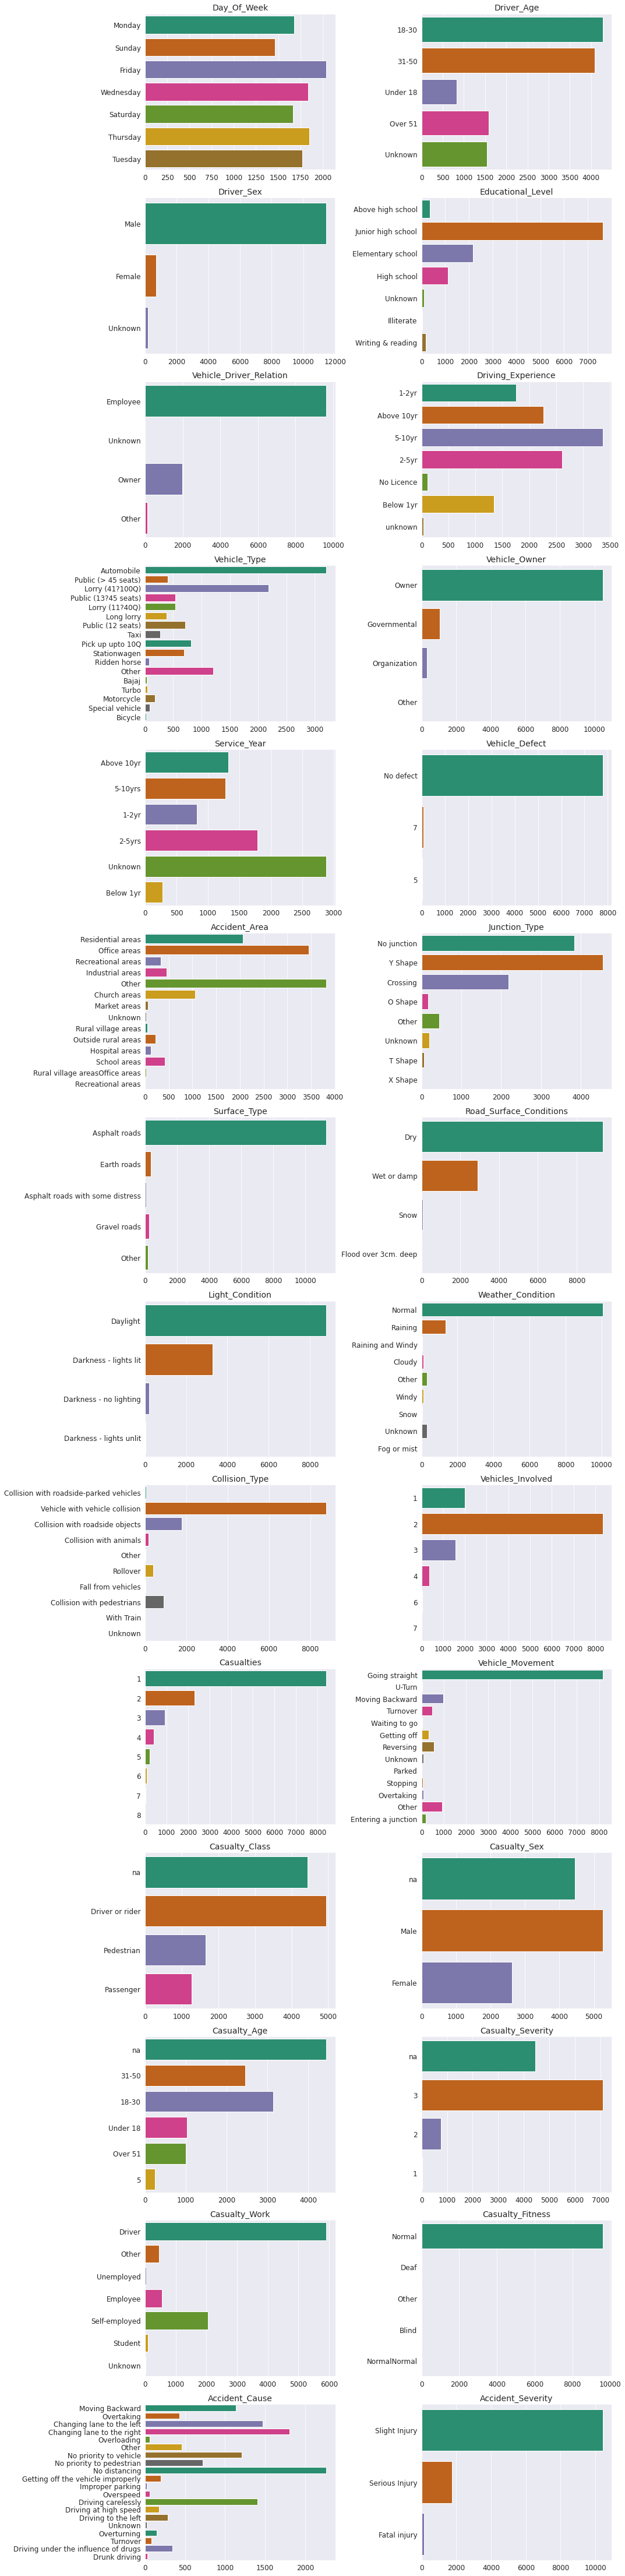

In [17]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in df.drop(['hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement'], axis=1):
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

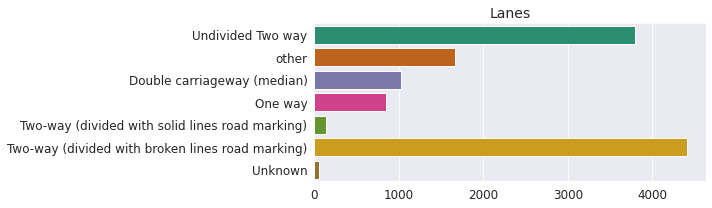

In [18]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='lanes', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lanes', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

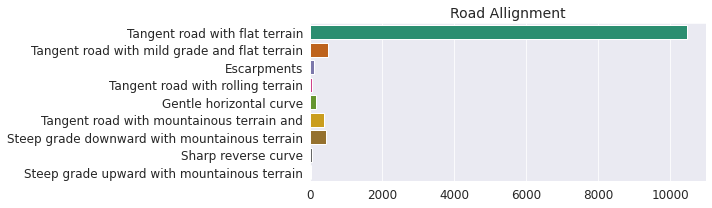

In [19]:
plt.figure(figsize=(10,3))
sns.countplot(data=df, y='road_allignment', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Road Allignment', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

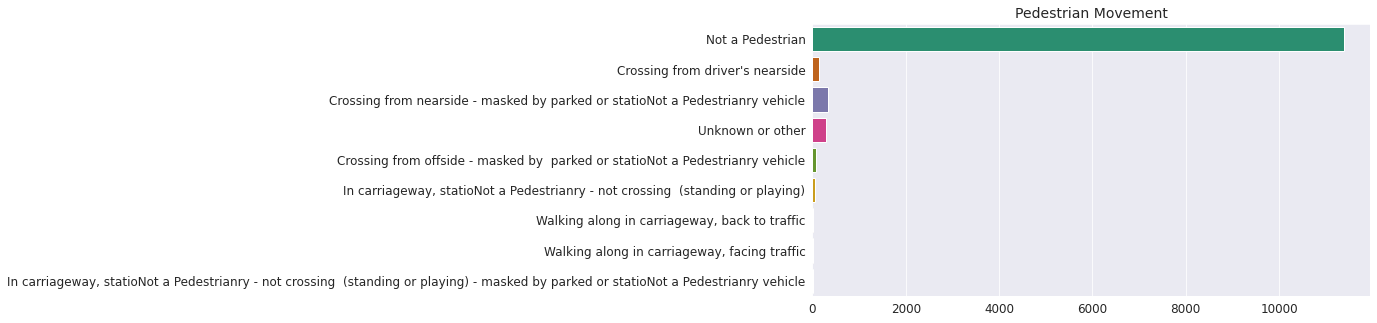

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='pedestrian_movement', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pedestrian Movement', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

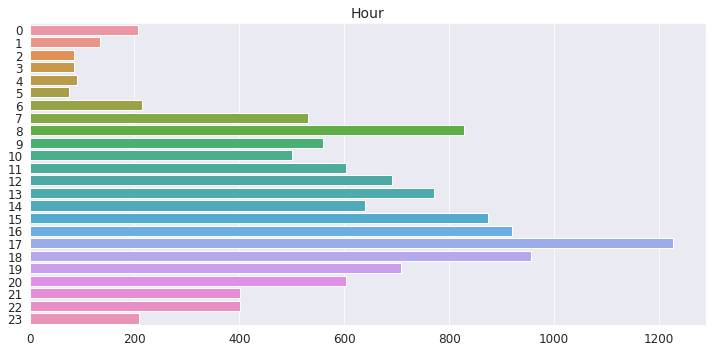

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='hour')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hour', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

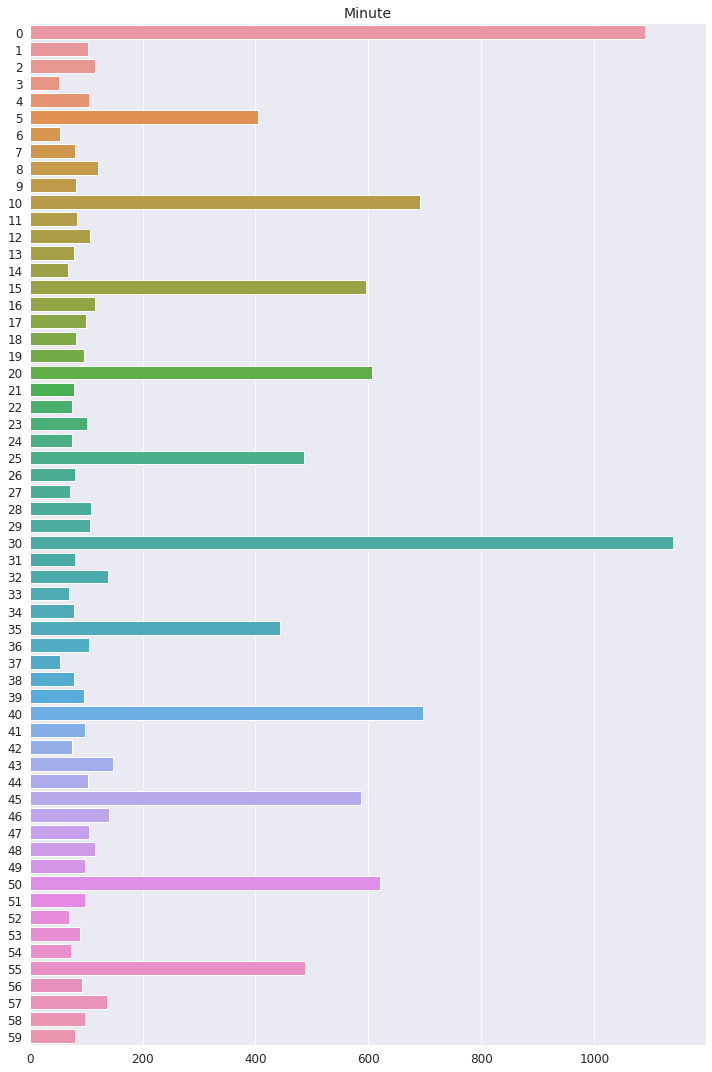

In [22]:
plt.figure(figsize=(10,15))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

#### **Observations**:

Most of the accidents:
* involved 2 vehicles and 2 casualties
* occured on Fridays and after noon hours

Most of the drivers:
* are male and in 18-30 yrs age group
* have only went upto Junior high school and are employees
* have 5-10 yrs of driving experience

Most of the accidents happened with personally owned passenger vehicles.

Most of the drivers have met with accident on:
* two-way lanes
* tangent road with flat terrains
* Y shaped junctions
* asphalt roads
* day time
* normal weather conditions

Most of the casualties:
* happened to physically fit male drivers
* are of severity 3

The conditions on which most of the drivers met with the accident are:
* vehicle to vehicle collision
* straight movement
* no pedestrian accidents

Not keeping enough distance between the vehicles was the major cause for most of the accidents and majority of the accidents resulted in slight injury.

#### Observations:
* Most of the accidents have taken place between 3pm to 6pm with maximum numbers at 5 pm
* Most of the time in minutes seems to have been recorded in intervals of 5 minutes for the sake of convenience. Hence more numbers to be seen at the 0 and 30 minutes.

In [27]:
min = list(range(5,56, 5))
def convert_minutes(x: int):
    for m in min:
        if x % m == x and x > m-5:
            return m
        if x in [56,57,58,59]:
            return 0
        if x in min+[0]:
            return x

In [28]:
df['minute'] = df['minute'].apply(lambda x: convert_minutes(x))

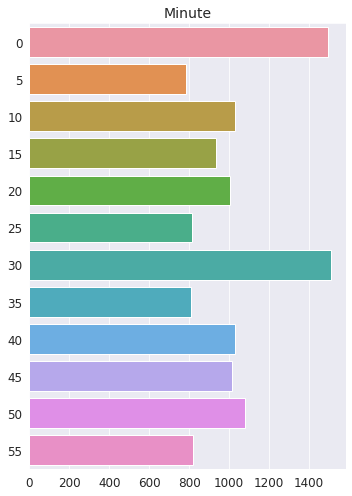

In [29]:
plt.figure(figsize=(5,7))
sns.countplot(data=df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [30]:
num_cols = df.dtypes[df.dtypes == 'int64'].index.tolist()
cat_cols = df.dtypes[df.dtypes != 'int64'].index.tolist()
df[cat_cols]

,day_of_week,driver_age,driver_sex,educational_level,vehicle_driver_relation,driving_experience,vehicle_type,vehicle_owner,service_year,vehicle_defect,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,casualty_work,casualty_fitness,pedestrian_movement,accident_cause,accident_severity
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,No defect,Residential areas,NaN,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,No defect,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,No defect,Recreational areas,other,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,No defect,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,No defect,Industrial areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,Wednesday,31-50,Male,NaN,Employee,2-5yr,Lorry (11?40Q),Owner,NaN,No defect,Outside rural areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,Going straight,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12312,Sunday,Unknown,Male,Elementary school,Employee,5-10yr,Automobile,Owner,NaN,No defect,Outside rural areas,Two-way (divided with broken lines road marking),Escarpments,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12313,Sunday,Over 51,Male,Junior high school,Employee,5-10yr,Bajaj,Owner,2-5yrs,No defect,Outside rural areas,Two-way (divided with broken lines road marking),Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,Other,Driver or rider,Male,31-50,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Serious Injury
12314,Sunday,18-30,Female,Junior high school,Employee,Above 10yr,Lorry (41?100Q),Owner,2-5yrs,No defect,Office areas,Undivided Two way,Tangent road with mountainous terrain and,No junction,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,Driving under the influence of drugs,Slight Injury


# Preprocessing

In [31]:
df.isna().sum()[df.isna().sum() != 0]

educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
collision_type              155
vehicle_movement            308
casualty_work              3198
casualty_fitness           2635
dtype: int64

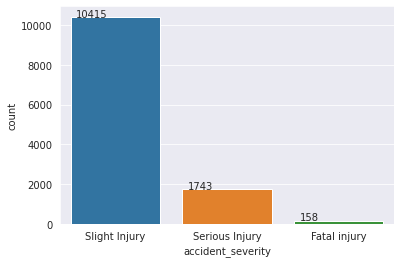

In [32]:
ax = sns.countplot(x=df["accident_severity"])
for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x()+0.05, p.get_height()+1))

plt.show()

In [33]:
# fig = plt.figure(figsize = (17,20))
# fig.subplots_adjust(hspace=1, wspace=0.6)
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
# cols = df.isna().sum()[df.isna().sum() != 0].index.tolist()
# for i,col in enumerate(cols):
#     ax = fig.add_subplot(4, 4, i+1)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
#     sns.countplot(x=df.dropna(subset=[col])["accident_severity"])
#     for p in ax.patches:
#       ax.annotate(f'{p.get_height()}', (p.get_x()+0.05, p.get_height()+1))
#     ax.set_title('column: ' + str(col))
# plt.show()

In [34]:
# dropping columns that can cause imbalance while imputation
df.drop(columns = ['vehicle_defect', 'vehicle_driver_relation', 'casualty_work', 'casualty_fitness',], inplace=True)

In [35]:
impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:
    mode = df[feat].mode()[0]
    df[feat].fillna(mode, inplace=True)

In [36]:
df.isna().sum() 
# 'na', 'Unknown'

day_of_week                0
driver_age                 0
driver_sex                 0
educational_level          0
driving_experience         0
vehicle_type               0
vehicle_owner              0
service_year               0
accident_area              0
lanes                      0
road_allignment            0
junction_type              0
surface_type               0
road_surface_conditions    0
light_condition            0
weather_condition          0
collision_type             0
vehicles_involved          0
casualties                 0
vehicle_movement           0
casualty_class             0
casualty_sex               0
casualty_age               0
casualty_severity          0
pedestrian_movement        0
accident_cause             0
accident_severity          0
hour                       0
minute                     0
dtype: int64

### Encoding

In [37]:
def ordinal_encoder(df, feats): 
    for feat in feats:    
        feat_val = list(1+np.arange(df[feat].nunique()))
        feat_key = list(df[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
        df[feat] = df[feat].map(feat_dict)
    return df

df = ordinal_encoder(df, df.drop(['accident_severity'], axis=1).columns)
df.shape

(12316, 29)

In [38]:
df

,day_of_week,driver_age,driver_sex,educational_level,driving_experience,vehicle_type,vehicle_owner,service_year,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,pedestrian_movement,accident_cause,accident_severity,hour,minute
0,2,1,2,1,1,1,4,4,10,3,6,2,1,1,4,3,4,2,2,3,4,3,6,4,6,10,Slight Injury,18,2
1,2,2,2,5,4,12,4,3,7,5,6,2,1,1,4,3,9,2,2,3,4,3,6,4,6,17,Slight Injury,18,2
2,2,1,2,5,1,6,4,6,2,7,6,2,1,1,4,3,3,2,2,3,1,2,2,3,6,1,Serious Injury,18,2
3,4,1,2,5,3,12,1,6,7,7,7,8,3,1,1,3,9,2,2,3,3,1,1,3,6,2,Slight Injury,2,3
4,4,1,2,5,2,1,4,3,5,7,6,8,1,1,1,3,9,2,2,3,4,3,6,4,6,17,Slight Injury,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,7,2,2,5,2,5,4,6,6,5,6,2,1,1,4,3,9,2,1,3,4,3,6,4,6,11,Slight Injury,17,4
12312,4,5,2,2,3,1,4,6,6,3,1,2,1,1,4,3,9,2,1,5,4,3,6,4,6,11,Slight Injury,19,1
12313,4,3,2,5,3,2,4,2,6,3,8,2,1,1,4,3,9,1,1,5,1,2,2,3,6,2,Serious Injury,14,12
12314,4,1,1,5,4,6,4,2,7,5,8,2,1,1,1,3,9,2,1,5,4,3,6,4,6,6,Slight Injury,14,12


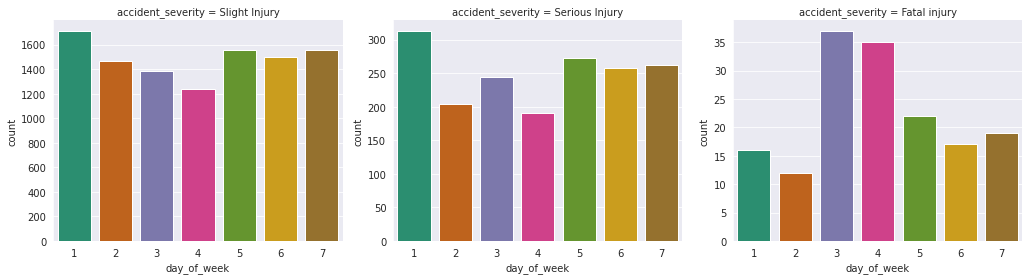

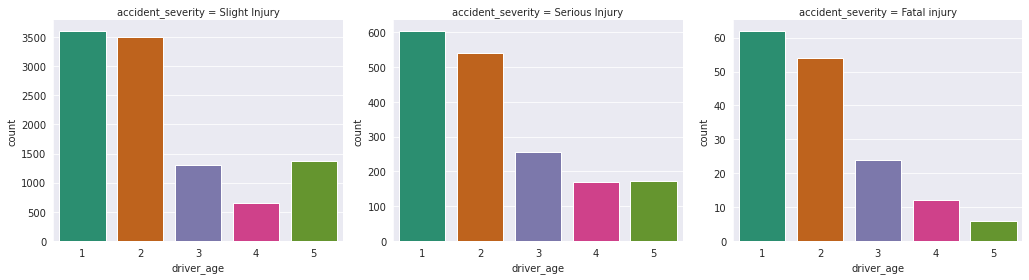

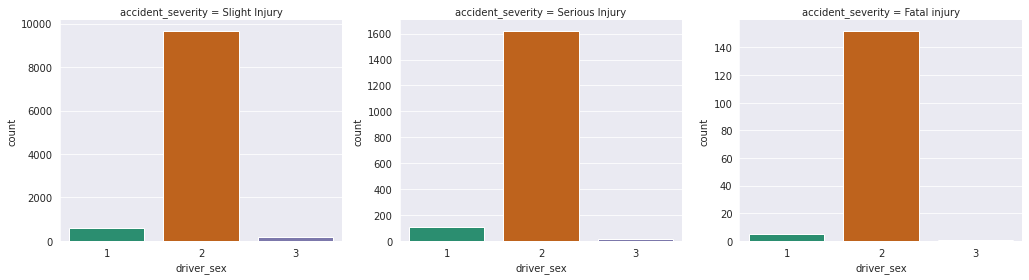

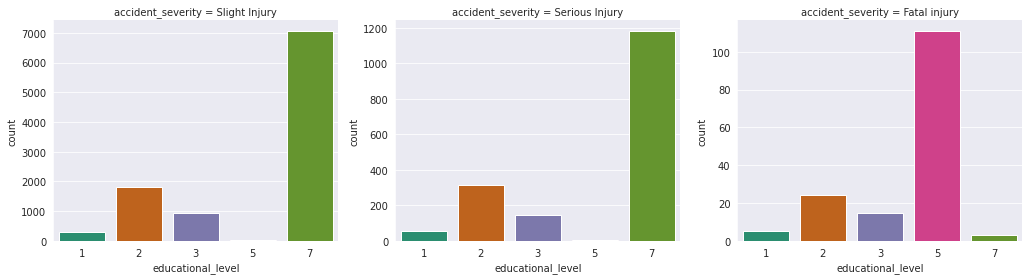

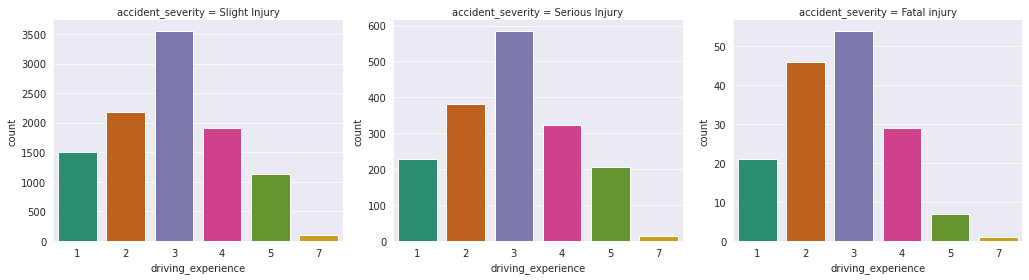

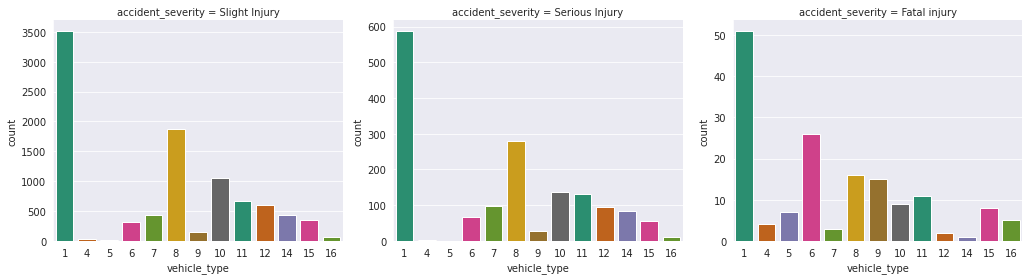

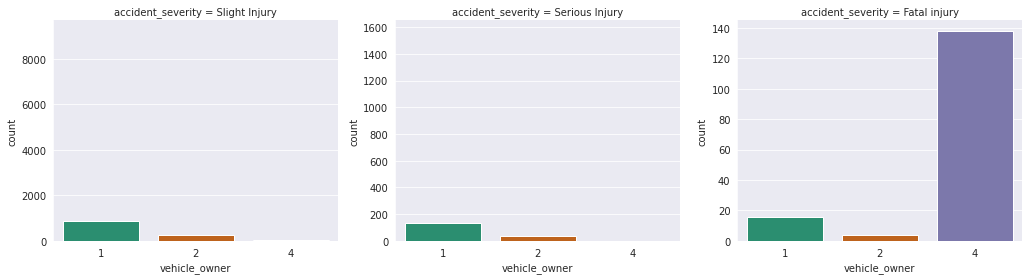

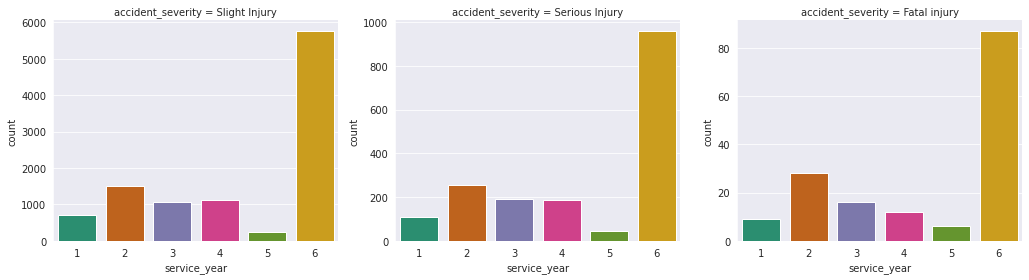

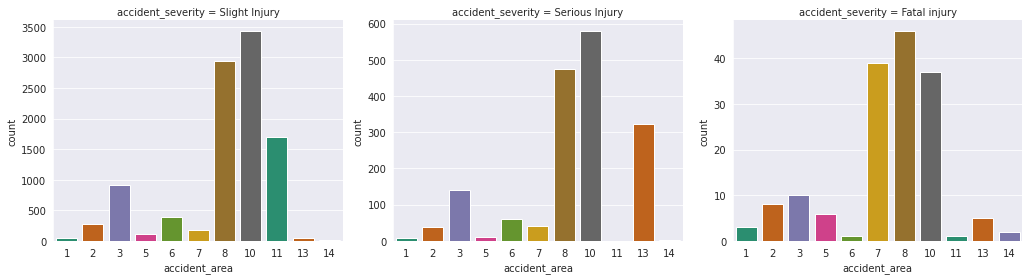

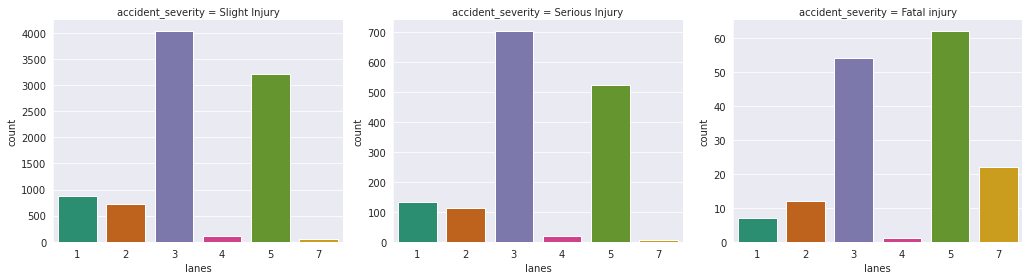

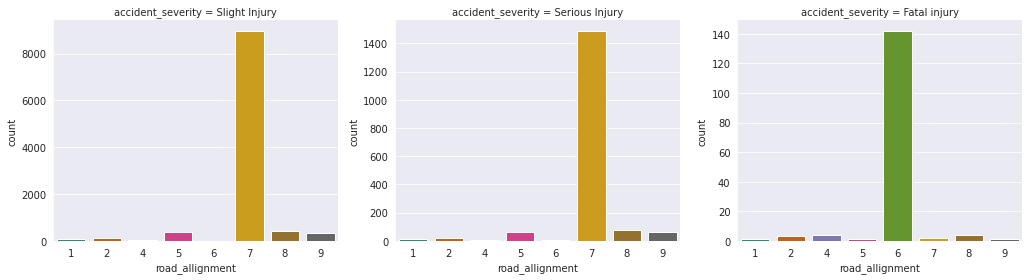

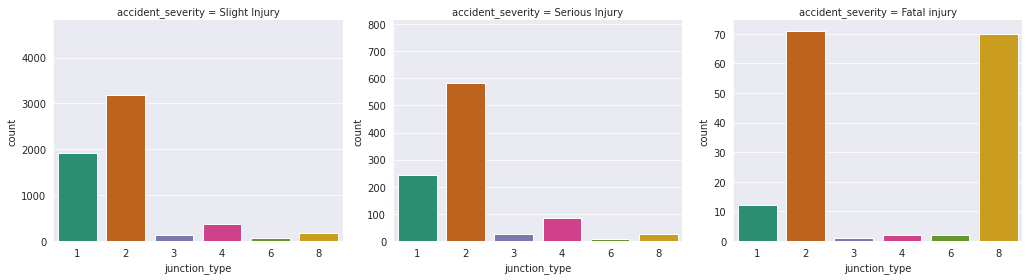

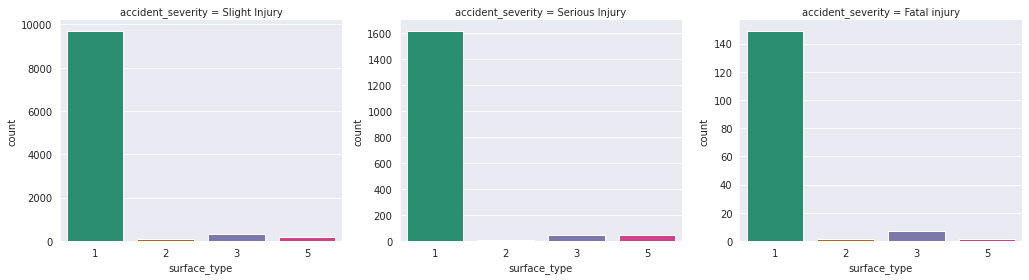

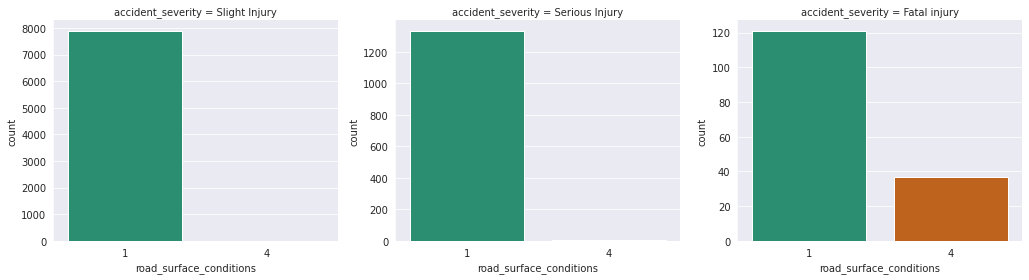

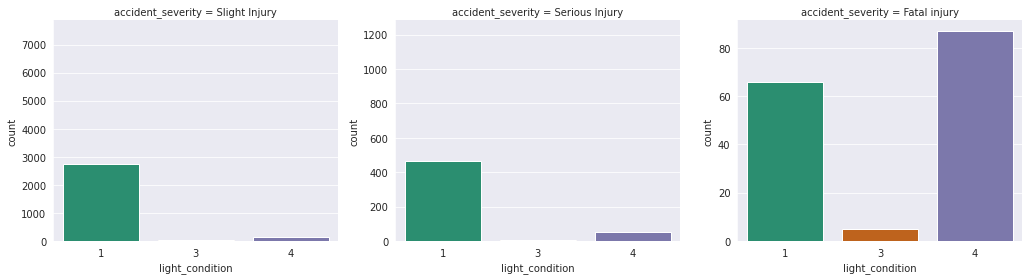

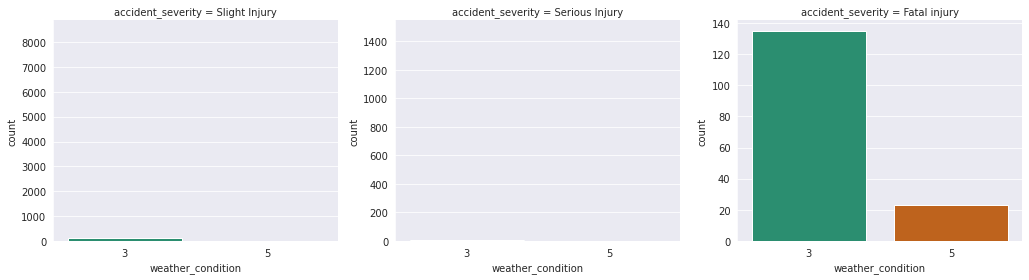

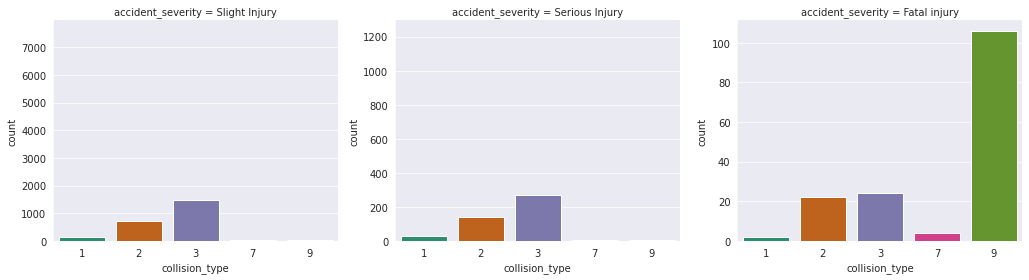

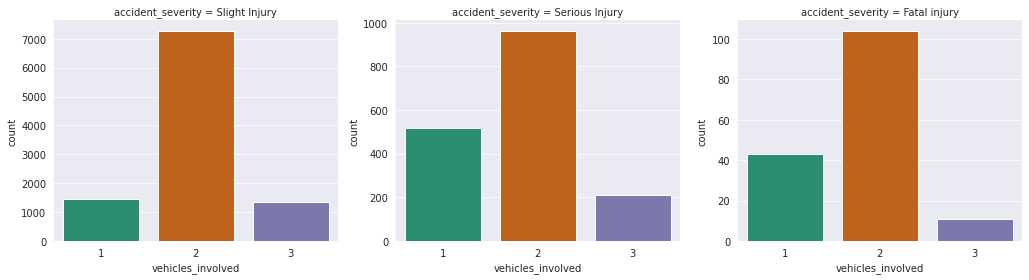

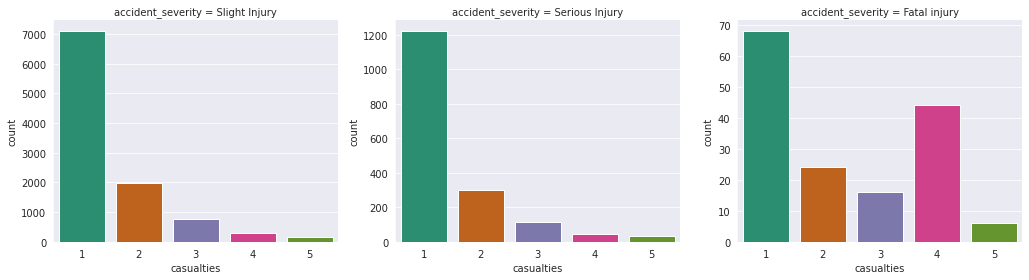

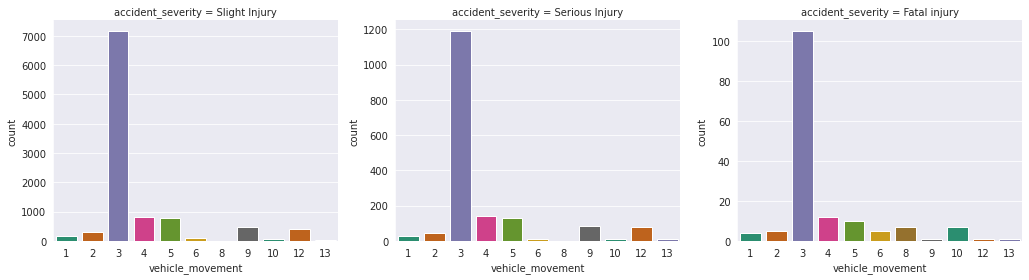

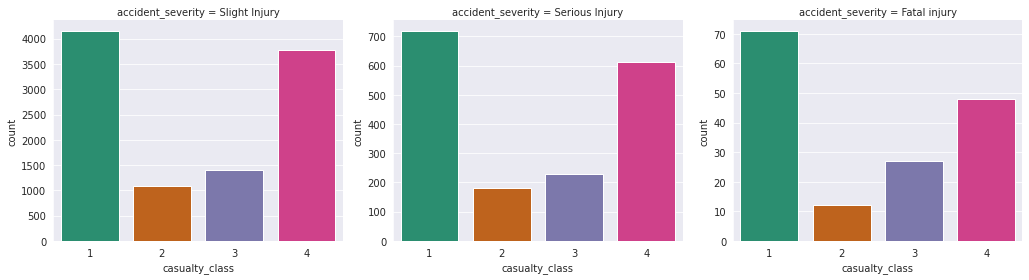

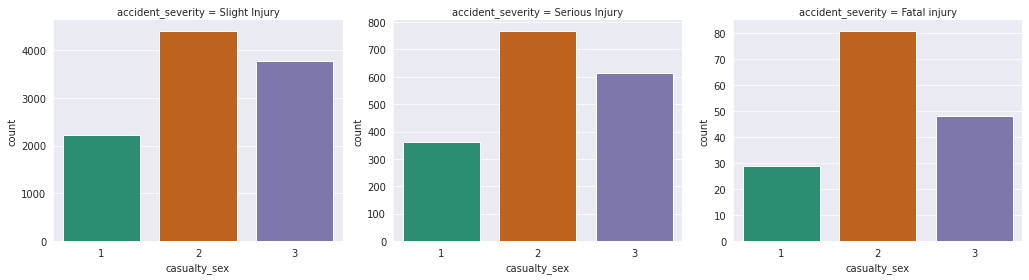

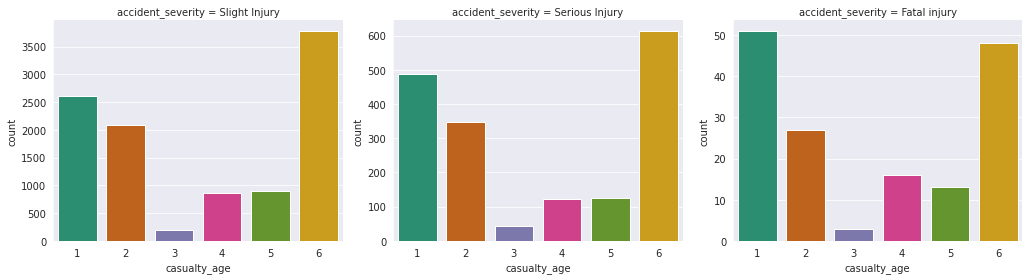

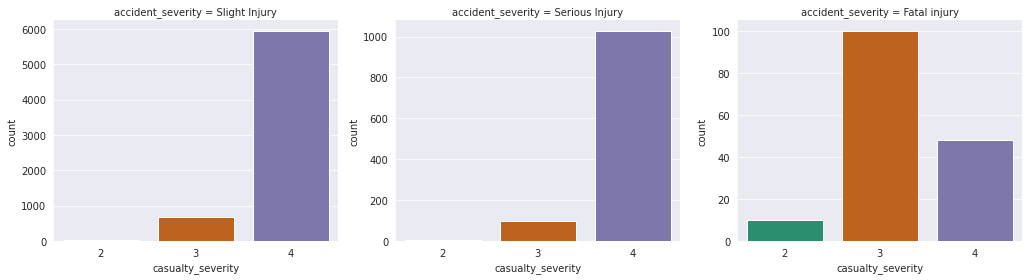

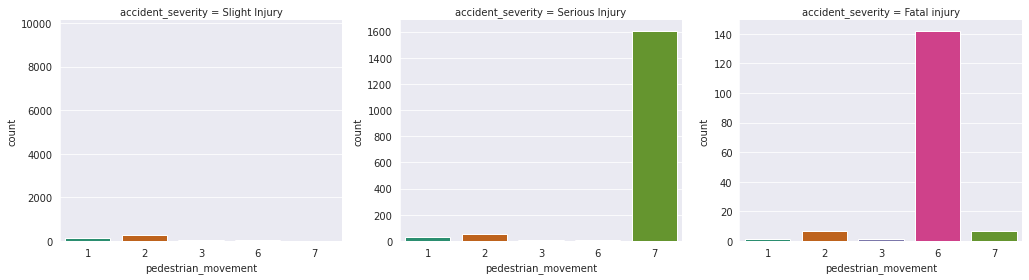

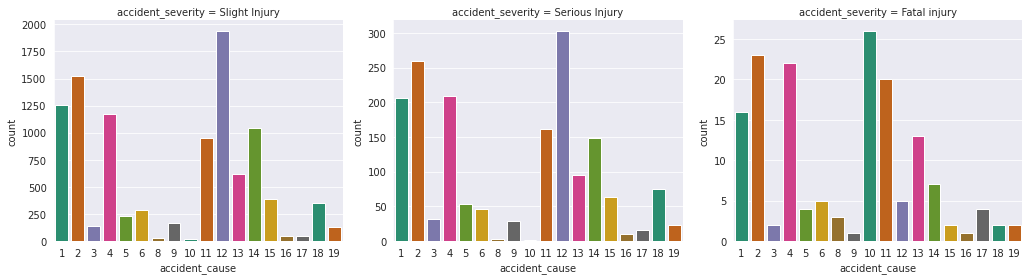

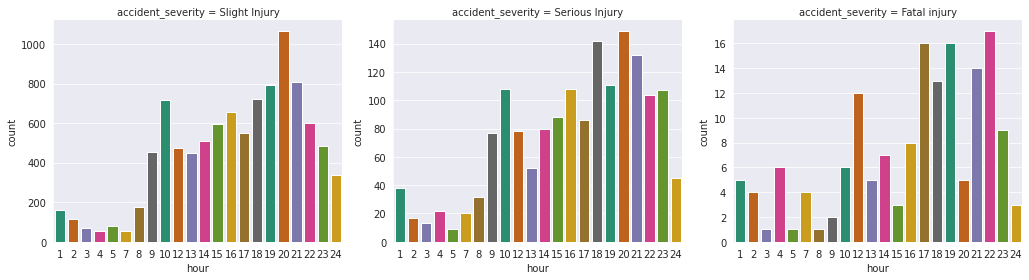

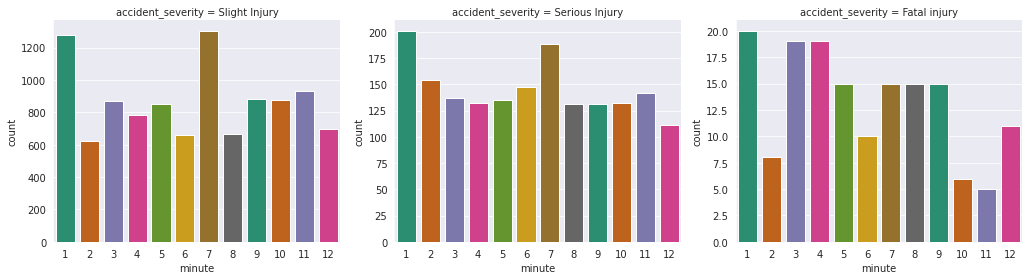

In [39]:
for col in df.drop('accident_severity', axis=1):
    g = sns.FacetGrid(df, col='accident_severity', size=4, aspect=1.2, sharey=False)
    g.map(sns.countplot, col, palette = 'Dark2')
    plt.show()

#### Observations:

* Most of the accidents with fatal injuries happened between 2pm to 7pm.
* Most of the accidents with fatal injuries happened on weekends.
* Highest number of non-fatal injuries happened at 5pm.
* Highest number of non-fatal injuries happened on fridays.
* Most accidents are caused by drivers aged 18-30 and the least by drivers aged under 18.
* Proportion of fatal accidents are lower for female drivers.
* Drivers with 2-5yrs of experience caused most accidents with fatal injury and those with 5-10yrs experience caused most accidents with non-fatal injuries.
* Proportion of fatal injuries caused by vehicles with more than 10yrs of service is lower compared to non-fatal injuries.
* Though most of the accident happened around offices, a higher proportion of accidents happened around residential areas have led to fatal injuries.
* Most accidents with fatal injuries occured on undivided two-ways.
* Most accidents with non-fatal injuries occured on two-way divided with broken lines road marking
* Double carriageway has a lower proportion of fatal accidents compared to non-fatal accidents.
* Severity of accidents increases at places with no junctions and the most number of fatal injuries occured at places with no junctions.
* Crossings and Y-shaped junctions shows a decreasing trend with respect to severity of accidents though the numbers are high.
* Most of the accidents with fatal injury have happened at night.
* Collisions with pedestrians have resulted in more fatal injuries compared to non-fatal injuries.
* Accidents with 4 casualties have a huge proportion on fatal injuries compared to non-fatal injuries.
* Accidents involving drivers with 18-30yrs of age have an increasing pattern with respect to severity of injuries.
* Moving backward led to most of the accidents with fatal injuries whereas failing to keep enough distance between vehicles led to more number of accidents with non-fatal injuries.

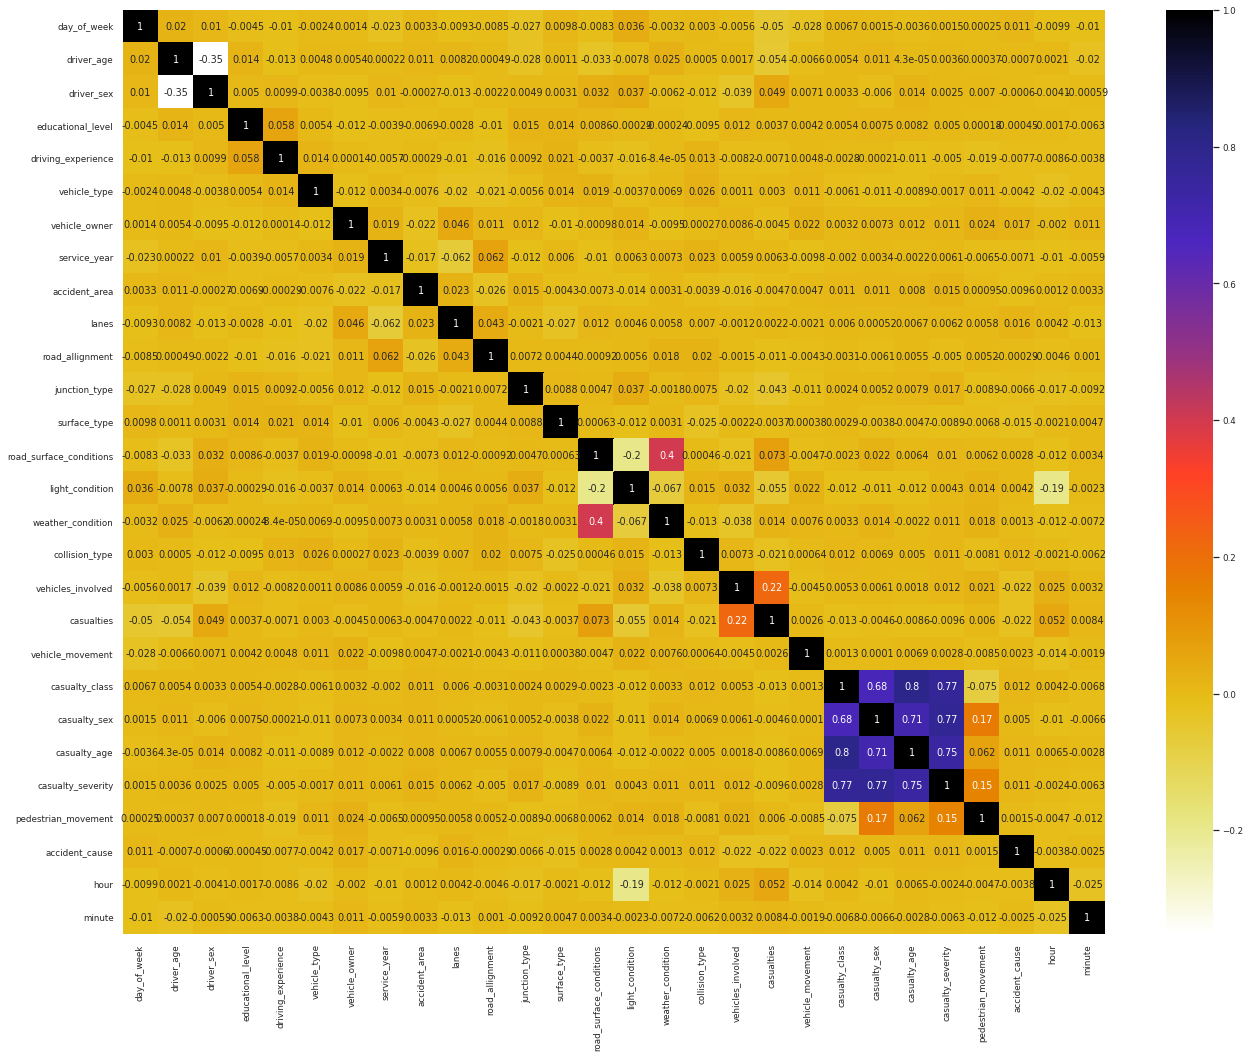

In [40]:
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

### Upsampling

In [41]:
X = df.drop('accident_severity', axis=1)
y = df['accident_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 28) (3695, 28) (8621,) (3695,)


In [42]:
# upsampling using smote

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Slight Injury, n=7324 (84.96%)
Class= Serious Injury, n=1191 (13.82%)
Class= Fatal injury, n=106 (1.23%)
Class= Slight Injury, n=7324 (33.33%)
Class= Serious Injury, n=7324 (33.33%)
Class= Fatal injury, n=7324 (33.33%)
Upsampled data shape:  (21972, 28) (21972,)


In [43]:
y_test

4281      Slight Injury
4010      Slight Injury
1022     Serious Injury
8775      Slight Injury
10000     Slight Injury
              ...      
9855      Slight Injury
7302     Serious Injury
9023      Slight Injury
7936      Slight Injury
438       Slight Injury
Name: accident_severity, Length: 3695, dtype: object

In [44]:
y_test = ordinal_encoder(pd.DataFrame(y_test, columns = ['accident_severity']), pd.DataFrame(y_test, columns = ['accident_severity']).columns)['accident_severity']
y_train = ordinal_encoder(pd.DataFrame(y_train, columns = ['accident_severity']), pd.DataFrame(y_train, columns = ['accident_severity']).columns)['accident_severity']

# Baseline Modeling

In [45]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred)]
#         scores['rf']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred)]
#         scores['extree']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(extree)
        
    return scores

In [46]:
modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)

{'extree': [0.8075778078484438],
 'rf': [0.7986468200270636],
 'xgb': [0.691745602165088]}

In [47]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)", "2 (pred)"],
                        y = ["0 (true)","1 (true)", "2 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    Accuracy  =  accuracy_score(y_test, y_hat)
    Precision =  precision_score(y_test, y_pred, average= 'weighted')
    Recall    =  recall_score(y_test, y_pred, average= 'weighted')
    F1_score  =  f1_score(y_test, y_pred, average= 'weighted')

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
 
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=1, print_grid=False, 
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = True, height = 800,width = 800,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        # margin = dict(b = 100)
                        )
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [48]:
extree = ExtraTreesClassifier()
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)

In [49]:
extree.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
model_performance(extree,y_test, y_pred)

# Hyperparameter Tuning

In [53]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

# A parameter grid for ETrees
params = {
    'n_estimators': range(100, 500, 100),
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['gini'],
    'max_depth': [5,11],
    'min_samples_split': [2,3],
}

extree_estimator = ExtraTreesClassifier()

gsearch = GridSearchCV(
    estimator= extree_estimator,
    param_grid= params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf,
    verbose=3,
)

extree_model = gsearch.fit(X=X_train, y=y_train)
(gsearch.best_params_, gsearch.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'ccp_alpha': 0.0,
  'criterion': 'gini',
  'max_depth': 11,
  'min_samples_split': 3,
  'n_estimators': 400},
 0.8600302455250671)

In [54]:
gkf2 = KFold(n_splits=3, shuffle=True, random_state=101).split(X=X_train, y=y_train)

params2 = {
    'n_estimators': range(400, 800, 100),
    'max_depth': [11,15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],

}

extree2 = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                max_depth = 11,
                                min_samples_split = 3,
                                n_estimators = 400)

gsearch2 = GridSearchCV(
    estimator= extree2,
    param_grid= params2,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=gkf2,
    verbose=3,
)

extree_model2 = gsearch2.fit(X=X_train, y=y_train)

(gsearch2.best_params_, gsearch2.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'class_weight': None,
  'max_depth': 15,
  'min_samples_split': 2,
  'n_estimators': 700},
 0.9225033463600911)

In [55]:
extree_tuned = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                min_samples_split = 2,
                                class_weight = 'balanced',
                                max_depth = 15,
                                n_estimators = 400)

extree_tuned.fit(X_train, y_train)
y_pred_tuned = extree_tuned.predict(X_test)

# Explainable AI

In [56]:
shap.initjs()

In [57]:
X_sample = X_train.sample(100)
X_sample

,day_of_week,driver_age,driver_sex,educational_level,driving_experience,vehicle_type,vehicle_owner,service_year,accident_area,lanes,road_allignment,junction_type,surface_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_sex,casualty_age,casualty_severity,pedestrian_movement,accident_cause,hour,minute
20033,1,1,2,4,4,7,4,6,7,7,6,8,1,3,1,4,9,2,2,3,4,3,6,4,6,4,23,2
18566,2,1,2,4,3,7,4,4,12,6,6,2,1,1,4,3,3,2,1,8,1,1,2,3,6,11,14,2
20976,6,2,2,5,3,5,3,3,7,3,6,8,2,2,4,3,2,2,1,3,1,1,1,3,6,4,17,4
21117,1,1,1,5,3,4,4,6,7,2,6,8,1,3,1,4,1,1,2,3,4,3,6,4,6,11,23,10
79,5,2,2,3,2,2,4,3,13,7,6,8,1,1,1,3,9,4,1,3,4,3,6,4,6,11,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9341,5,2,2,5,2,11,3,6,8,3,6,6,1,1,4,3,7,2,2,3,4,3,6,4,6,10,19,1
18838,3,2,2,2,2,6,4,1,7,6,6,6,1,1,4,3,9,1,2,3,1,1,4,2,6,10,13,8
9431,3,1,2,1,3,3,4,3,7,2,6,1,1,1,2,3,9,2,1,10,1,1,1,3,6,3,18,2
5227,7,1,2,2,3,1,4,2,8,3,6,8,1,4,1,3,3,2,1,3,4,3,6,4,6,11,18,12


In [58]:
shap_values = shap.TreeExplainer(extree_tuned).shap_values(X_sample)

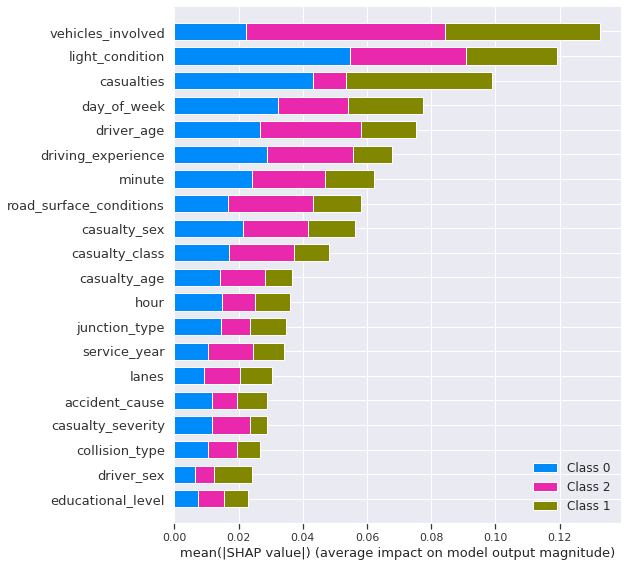

In [59]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

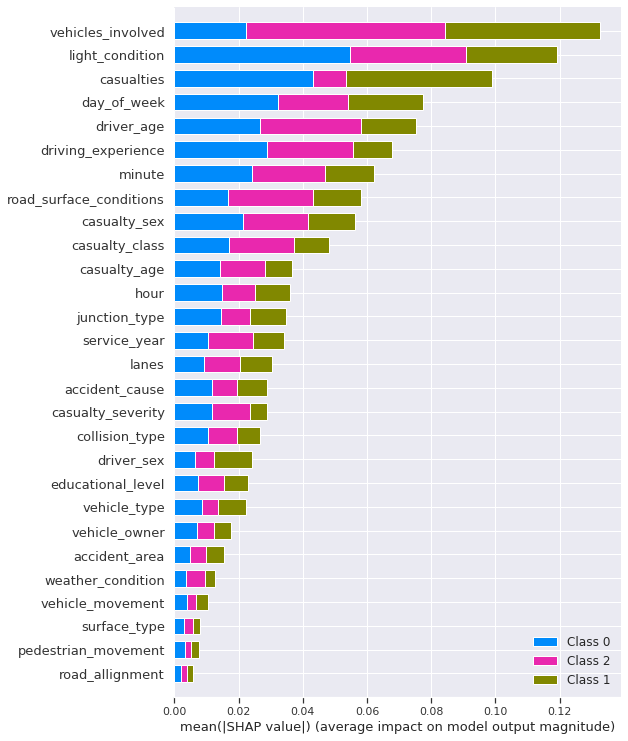

In [60]:
shap.summary_plot(shap_values, X_sample, max_display=28)

In [61]:
shap.force_plot(shap.TreeExplainer(extree_tuned).expected_value[0],
                shap_values[0][:], 
                X_sample)

In [62]:
print(y_pred_tuned[50])
shap.force_plot(shap.TreeExplainer(extree_tuned).expected_value[0], shap_values[1][50], X_sample.iloc[50])

3


In [63]:
i=13
print(y_pred_tuned[i])
shap.force_plot(shap.TreeExplainer(extree_tuned).expected_value[0], shap_values[0][i], X_sample.values[i], feature_names = X_sample.columns)

2


3


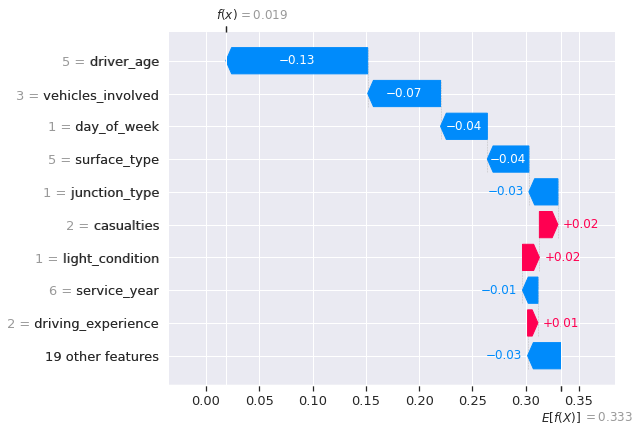

In [64]:
print(y_pred_tuned[10])
row = 10
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=shap.TreeExplainer(extree_tuned).expected_value[0], data=X_sample.iloc[row],  
                                         feature_names=X_sample.columns.tolist()))

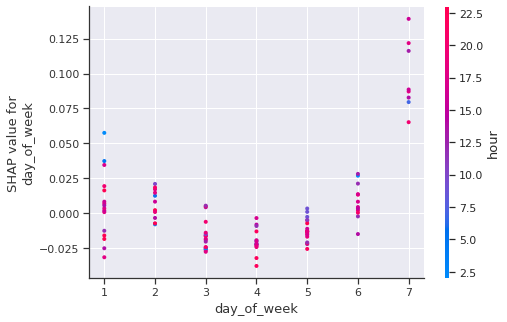

In [65]:
shap.dependence_plot('day_of_week', shap_values[2], X_sample)

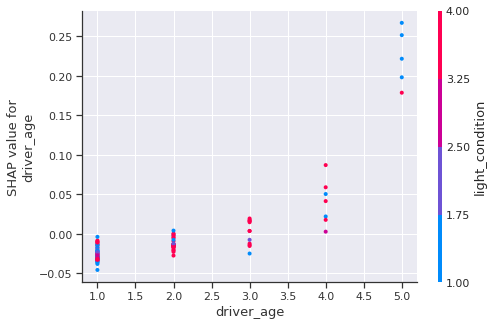

In [66]:
shap.dependence_plot('driver_age', shap_values[2], X_sample)

3


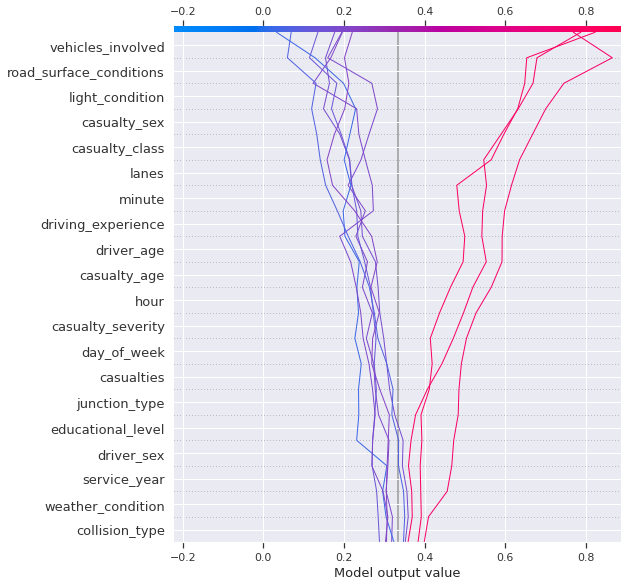

In [67]:
print(y_pred_tuned[10])
shap.decision_plot(shap.TreeExplainer(extree_tuned).expected_value[0], 
                   shap_values[2][:10], 
                   feature_names=X_sample.columns.tolist())